# Model: CNN

**Neural Network**
- 2 Hidden Layers, 2 Dropouts

**Compiler**

- loss function: binary crossentropy
- optimizer: adam

**Fit**

- 7 Epochs

**Metrics**
- Recall for train: .96 
- Recall for val: .875



In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 84, 84, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 84, 84, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 84, 84, 32)        4640      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 84, 84, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 32)       

## Import

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

import os
import sys
import warnings
warnings.filterwarnings('ignore')
#!{sys.executable} -m pip install opencv-python

import time
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

import scipy
from PIL import Image
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import models
from keras import layers
import keras_metrics
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV, validation_curve 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, validation_curve
from sklearn.pipeline import make_pipeline
#from tensorflow.keras import get_default_graph
np.random.seed(123)

Using TensorFlow backend.


## Model Prep

In [20]:
#confusion matrix code
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
#define data path
test_folder = 'Data/test'
train_folder = 'data/train'
val_folder = 'data/val'

In [7]:
# Prep data for processing
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(256,256), batch_size = 627) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(256,256), batch_size = 19)

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(256,256), batch_size=5219)

train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [42]:
len(test_images)

624

## Model

In [19]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(0.05))  

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(0.05))  

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((3, 3)))
#model.add(layers.Dropout(0.0025)) 

model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))


# model.add(layers.Flatten())

# model.add(layers.Dense(64, activation='relu'))
# #model.add(layers.Dropout(0.4))
# model.add(layers.Dense(2 , activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',keras_metrics.recall()])
model.summary()

tracking <tf.Variable 'Variable_2:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_3:0' shape=() dtype=int32> fn
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 84, 84, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 84, 84, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 84, 84, 32)        4640      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 84, 84, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 32)        0      

In [31]:
history = model.fit(train_images,
                    train_y,
                    epochs=7,
                    batch_size=32,
                    validation_split= 0.1,
                    #validation_data=(val_images, val_y)
                    verbose=1)

Train on 4694 samples, validate on 522 samples
Epoch 1/7
4694/4694 [==============================] - 133s 28ms/step - loss: 0.3356 - acc: 0.8479 - recall: 0.3082 - val_loss: 0.1176 - val_acc: 0.9559 - val_recall: 0.9290
Epoch 2/7
4694/4694 [==============================] - 123s 26ms/step - loss: 0.1163 - acc: 0.9589 - recall: 0.9076 - val_loss: 0.0785 - val_acc: 0.9636 - val_recall: 0.8889
Epoch 3/7
4694/4694 [==============================] - 127s 27ms/step - loss: 0.0891 - acc: 0.9687 - recall: 0.9490 - val_loss: 0.0722 - val_acc: 0.9674 - val_recall: 0.8835
Epoch 4/7
4694/4694 [==============================] - 122s 26ms/step - loss: 0.0769 - acc: 0.9700 - recall: 0.9324 - val_loss: 0.0685 - val_acc: 0.9732 - val_recall: 0.9346
Epoch 5/7
4694/4694 [==============================] - 122s 26ms/step - loss: 0.0690 - acc: 0.9742 - recall: 0.9492 - val_loss: 0.0803 - val_acc: 0.9713 - val_recall: 0.9414
Epoch 6/7
4694/4694 [==============================] - 130s 28ms/step - loss: 0.058

In [32]:
results_train = model.evaluate(train_images, train_y)
results_test = model.evaluate(val_images, val_y)

16/16 [==============================] - 0s 19ms/step


In [33]:
results_train

[0.03979605585629509, 0.9838957190513611, 0.997648298740387]

In [34]:
results_test

[0.11767389625310898, 0.9375, 0.875]

Confusion Matrix, without normalization
[[8 0]
 [1 7]]
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94         8
         1.0       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16

roc_auc_score: 0.9375


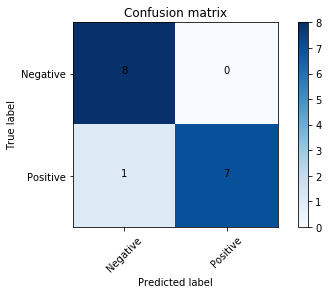

In [46]:
y_pred = model.predict_classes(val_images)

cm = confusion_matrix(val_y, y_pred)
classes = ['Negative', 'Positive']

plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix'
                     )
plt.figsize=(10,10)
plt.savefig('Images/conf.png')
#Checking performance our model with classification report.
print(classification_report(val_y, y_pred))
#Checking performance our model with ROC Score.
print ('roc_auc_score:', roc_auc_score(val_y, y_pred))